# Import and functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from numpy import linalg as la
from scipy.optimize import curve_fit

%matplotlib inline

In [2]:
def Gaussian_filter_1d(x,s):
    return(np.exp(-(x/s)**2/2))/s/np.sqrt(np.pi*2)

def NGD3L1D_STK(xAxis, tAxis, sigma_dict, tPara_ict, spaceDivideStep = 1, timeDivideStep = 60):
# divideStep upsample rate
# tPara_dict must include these temporal parameters: alpha, beta, gamma, g, h, l 
    dx = np.mean(np.diff(xAxis)) / spaceDivideStep
    xAxis = AxisByHalfLen(xAxis[-1], dx)
    gaussK = {} # Gassian Kernel
    for (key,value) in sigma_dict.items():
        halfKLen = min( value*8, xAxis[-1])
        kAxis = AxisByHalfLen(halfKLen, dx)
        gaussK[key] = Gaussian_filter_1d(kAxis,value)

    dt = np.mean(np.diff(tAxis)) / timeDivideStep
    tAxis = np.arange(0, tAxis[-1]+dt, dt)
    stimulus = np.zeros([len(tAxis), len(xAxis)])
    if "tau_delay" in tPara_ict:
        delayed_delta = tAxis /tPara_dict['tau_delay']/tPara_dict['tau_delay'] *np.exp(-tAxis/tPara_dict['tau_delay']) *dt
        stimulus[:,int(len(xAxis)/2)] = delayed_delta
    else:
        stimulus[0,int(len(xAxis)/2)] = 1

    z = np.zeros_like(stimulus)
    y = np.zeros_like(stimulus)
    w = np.zeros_like(stimulus)

    for i in np.arange(len(tAxis)-1):
        R = {'y2z':y[i,:], 'y2w':y[i,:], 'z2y':z[i,:], 'z2w':z[i,:]}
        for key in R.keys():
            if key in gaussK:    R[key] = np.convolve(R[key],gaussK[key],'same')*dx

        dy = (-tPara_dict['alpha']*y[i,:] +            stimulus[i,:] -                 R['z2y'])*dt
        dz = (-tPara_dict['beta'] *z[i,:] + tPara_dict['g']*R['y2z']                           )*dt
        dw = (-tPara_dict['gamma']*w[i,:] +                 R['y2w'] - tPara_dict['l']*R['z2w'])*dt

        y[i+1,:] = (y[i,:]+dy)
        z[i+1,:] = (z[i,:]+dz)
        w[i+1,:] = (w[i,:]+dw)
    actual_xAxisIndex = np.append( np.arange(int(len(xAxis)/2), -1, -spaceDivideStep)[:0:-1], np.arange(int(len(xAxis)/2), len(xAxis), spaceDivideStep) )
    y = y[::timeDivideStep, actual_xAxisIndex]/dx/dt #
    z = z[::timeDivideStep, actual_xAxisIndex]/dx/dt
    w = w[::timeDivideStep, actual_xAxisIndex]/dx/dt

    return tPara_dict['m']*w, z, y

def AxisByHalfLen(halfLen, dx):
    axis = np.arange(0, halfLen+dx, dx)
    return np.append(-1*axis[:0:-1], axis)


## Temporal 

In [3]:
dt = 0.01 #large dt will cause  overflow
Tstep = int(1./dt)
TKtaxis = np.arange(Tstep)*dt

tPara_dict = {
'alpha':1.302408,
'beta':13.024075,
'gamma':34.901452,
'g':460.016331,
'l':0.021331,
'tau_delay':0.028650,
'm':127.832600} # m can be nagative for off cell

## Spatial 

In [4]:
sigma_dict = dict()
sigma_dict['y2w'] = 0.20426678569344126 *1.1 #mm from exp data (RF radius = 1.5*sigma)
sigma_dict['z2w'] = 3*sigma_dict['y2w'] # 
sigma_dict['y2z'] = 0.05*sigma_dict['y2w'] # has to be small enough

dx = 0.005 # OLED pixel2micro = 7.6
hXstep =  int(2 /dx) #Half length of xais, (mm)
# hXstep =  int(1.015 /dx) #range of Checkboard, 1.5*sqrt(2)/2
SKxaxis = np.arange(-hXstep,hXstep+1)*dx

In [5]:
sigma_dict

{'y2w': 0.2246934642627854,
 'z2w': 0.6740803927883562,
 'y2z': 0.01123467321313927}

# STK

In [6]:
Delta_output_w, zts, Delta_output_y = NGD3L1D_STK(SKxaxis, TKtaxis, sigma_dict, tPara_dict)

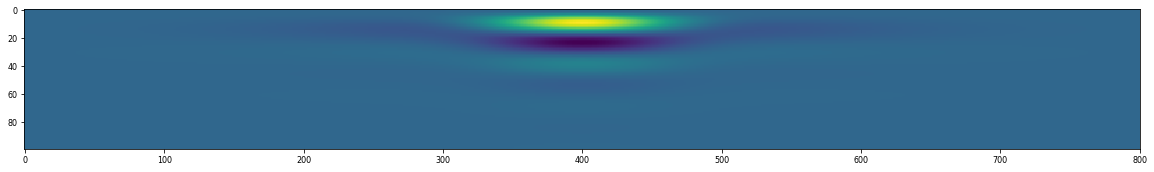

In [15]:
plt.imshow(Delta_output_w)
plt.gcf().set_size_inches(20, 5)


In [8]:
delSTK = Delta_output_w

In [9]:
iSK = np.sum(delSTK, axis = 0)*dt
iTK = np.sum(delSTK, axis = 1)*dx
SeSTK = iTK[:, np.newaxis]*iSK[np.newaxis, :]
SeSTK = SeSTK/np.max(SeSTK)*np.max(delSTK)

# SVD

In [10]:
U,sigma,VT=la.svd(delSTK)

In [11]:
print((sigma/sum(sigma))[:5])
for i in range(2):
    if U[2,i] <0:
        VT[i,:] = -VT[i,:]
        U[:,i] = -U[:,i]
        

SVDSTK = U[:,0][:, np.newaxis]*VT[0,:][np.newaxis, :]*sigma[0]

[8.49887967e-01 1.49680741e-01 3.63034628e-04 3.01721597e-05
 2.25854980e-05]


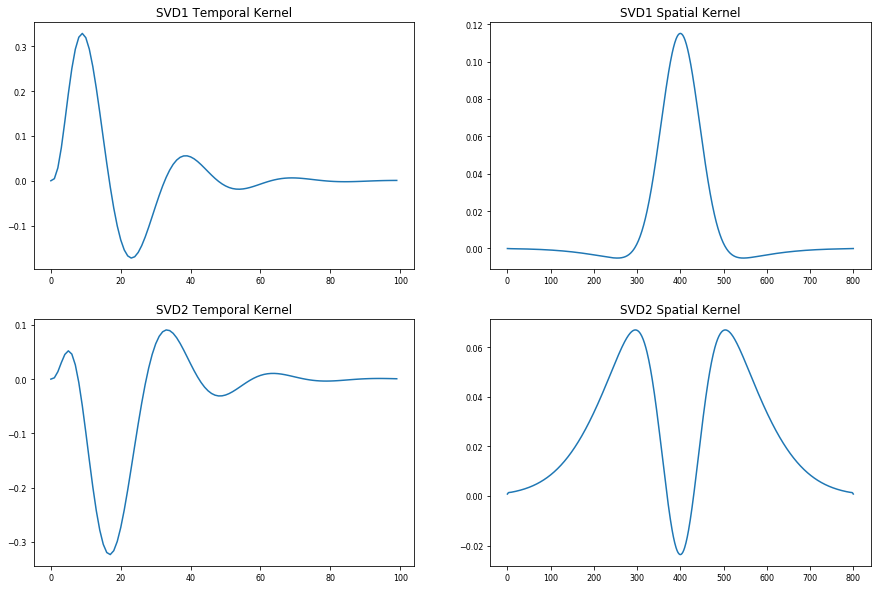

In [12]:
fig, ((ax2, ax3), (ax4, ax5)) = plt.subplots(nrows=2, ncols=2)
ax2.plot(U[:,0])
ax2.set_title('SVD1 Temporal Kernel')
ax3.plot(VT[0,:])
ax3.set_title('SVD1 Spatial Kernel')
ax4.plot(U[:,1])
ax4.set_title('SVD2 Temporal Kernel')
ax5.plot(VT[1,:])
ax5.set_title('SVD2 Spatial Kernel')
fig.set_size_inches(15, 10)

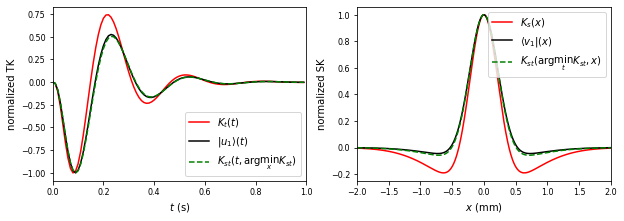

In [18]:
fig, ax = plt.subplots(1,2)
ax[1].plot(SKxaxis, iSK/np.max(iSK), 'r',label=r'$K_s(x)$')
ax[1].plot(SKxaxis, VT[0,:]/np.max(VT[0,:]), 'k',label=r'$\left\langle {v_1} \right|(x)$')
ax[1].plot(SKxaxis, delSTK[np.where(delSTK == np.max(delSTK))[0][0], :]/np.max(delSTK), 'g--',label=r'$K_{st}(\arg\min_{t} K_{st}, x)$')
ax[1].legend(loc='best')
ax[1].set_ylabel('normalized SK')
ax[1].set_xlabel(r'$x$ (mm)')
ax[1].set_xlim([-2,2])

ax[0].plot(TKtaxis, -iTK/np.max(iTK), 'r',label=r'$K_t(t)$')
ax[0].plot(TKtaxis, -U[:,0]/np.max(U[:,0]), 'k', label=r'$\left| u_1 \right\rangle(t)$')
ax[0].plot(TKtaxis, -delSTK[:, np.where(delSTK == np.max(delSTK))[1][0]]/np.max(delSTK), 'g--',label=r'$K_{st}(t, \arg\min_{x} K_{st})$')
ax[0].set_xlabel(r'$t$ (s)')
ax[0].set_ylabel('normalized TK')
ax[0].set_xlim([0,1])
# ax[0].plot(TKtaxis, U[:,1]/np.max(U[:,1]) *sigma[1]/sigma[0], label='u2')

ax[0].legend(loc='best')
fig.set_size_inches(10,3.2)

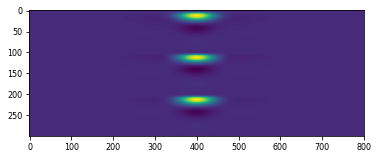

In [ ]:
plt.imshow(np.vstack((delSTK,SeSTK,SVDSTK)))

# Steady State of Constant Moving Bar
SK of moving frame

In [19]:
def SquareWave(width, dx): #width in mm
    halfWidth = int( (width/dx-1)/2 + 0.5) # halfWidth is dimensionless
    return np.ones(2*halfWidth+1), (2*halfWidth+1)*dx # return a square wave and the actual width of it

def GaussianWave(sigma, dx): # sigma is dimensionless
    s = int(sigma/dx + 0.5) # s is dimensionless
    xaxis = np.arange(-5*s, 5*s+1)
    return (np.exp(-(xaxis/s)**2/2)), s*dx # return a Gaussian wave and the actual sigma of it

In [20]:
def StadyState_ConstMoveDelta(v, Kernel, dx, dt): 
    v = v*dt/dx #dimensionless v
    if Kernel.shape[1]%2 == 0: return
    addlen = int(v*(Kernel.shape[0]-1))
    
    xaxis = np.arange(-int(Kernel.shape[1]/2)-addlen, int(Kernel.shape[1]/2)+1)*dx
    last_mb_y = np.zeros_like(xaxis)
    for k in range(Kernel.shape[0]):
        shift = int(v*k)
        last_mb_y += np.hstack((np.zeros(addlen-shift) ,Kernel[k,:], np.zeros(shift)))*dt
    return last_mb_y, xaxis

## Control: v,  Independent: hw and $\sigma$

In [21]:
v = 0.44 #mm/s #berry
delSKvp, xaxis = StadyState_ConstMoveDelta(v, delSTK, dx, dt)
SeSKvp,  xaxis = StadyState_ConstMoveDelta(v, SeSTK,  dx, dt)
SVDSKvp, xaxis = StadyState_ConstMoveDelta(v, SVDSTK, dx, dt)

In [22]:
np.where(xaxis==0)

(array([487], dtype=int64),)

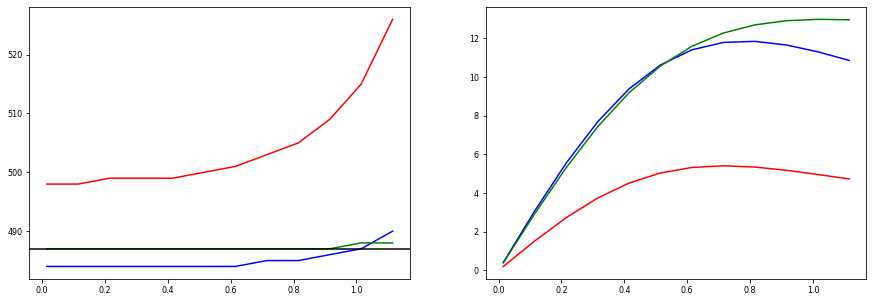

In [35]:
fig, ax = plt.subplots(1,2)
hw_list = np.arange(10, 1200, 100)*1E-3 # it is 0.129 mm in our exp. and 0.133 mm in Berry's.
squareWave_list = np.array([SquareWave(hw, dx) for hw in hw_list])


del_hw2y = np.array([np.convolve(delSKvp, squareWave[0], 'same') for squareWave in squareWave_list])
se_hw2y  = np.array([np.convolve(SeSKvp , squareWave[0], 'same') for squareWave in squareWave_list])
svd_hw2y = np.array([np.convolve(SVDSKvp, squareWave[0], 'same') for squareWave in squareWave_list])


ax[0].plot(squareWave_list[:, 1], np.argmax(del_hw2y, axis = 1), c='b')
ax[0].plot(squareWave_list[:, 1], np.argmax(se_hw2y, axis = 1), c='r')
ax[0].plot(squareWave_list[:, 1], np.argmax(svd_hw2y, axis = 1), c='g')
ax[0].axhline( np.where(xaxis==0), c = 'k' )
ax[1].plot(squareWave_list[:, 1], np.max(del_hw2y, axis = 1), c='b')
ax[1].plot(squareWave_list[:, 1], np.max(se_hw2y, axis = 1), c='r')
ax[1].plot(squareWave_list[:, 1], np.max(svd_hw2y, axis = 1), c='g')
fig.set_size_inches(15,5)

TypeError: GaussianWave() missing 1 required positional argument: 'dx'

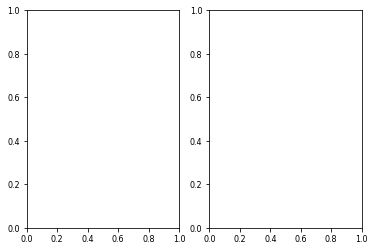

In [32]:
fig, ax = plt.subplots(1,2)
sigma_list = np.arange(1,55,0.5)

del_sigma2y = np.array([np.convolve(delSKvp, GaussianWave(sig), 'same') for sig in sigma_list])
se_sigma2y  = np.array([np.convolve(SeSKvp , GaussianWave(sig), 'same') for sig in sigma_list])
svd_sigma2y = np.array([np.convolve(SVDSKvp, GaussianWave(sig), 'same') for sig in sigma_list])


ax[0].plot(sigma_list, np.argmax(del_sigma2y, axis = 1), c='b')
ax[0].plot(sigma_list, np.argmax(se_sigma2y, axis = 1), c='r')
ax[0].plot(sigma_list, np.argmax(svd_sigma2y, axis = 1), c='g')
ax[0].axhline( np.where(xaxis==0), c = 'k' )
ax[1].plot(sigma_list, np.max(del_sigma2y, axis = 1), c='b')
ax[1].plot(sigma_list, np.max(se_sigma2y, axis = 1), c='r')
ax[1].plot(sigma_list, np.max(svd_sigma2y, axis = 1), c='g')
    
fig.set_size_inches(15,5)

## Control: hw and $\sigma$,  Independent: v

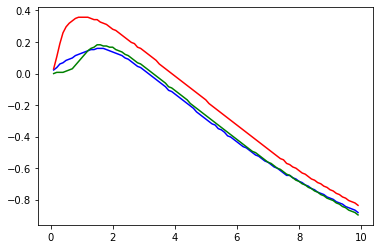

In [ ]:
hw = 80
del_preceed = []
Se_preceed = []
SVD_preceed = []
v_list = np.arange(0.1,10,0.1)
for v in v_list:
    delSKvp, xaxis = StadyState_ConstMoveDelta(v, delSTK, dx, dt)
    delSKvphw = np.convolve(delSKvp , SquareWave(hw), 'same')
    del_preceed.append(xaxis[np.argmax(delSKvphw)])
    
    SeSKvp, xaxis = StadyState_ConstMoveDelta(v, SeSTK, dx, dt)
    SeSKvphw = np.convolve(SeSKvp , SquareWave(hw), 'same')
    Se_preceed.append(xaxis[np.argmax(SeSKvphw)])

    
    SVDSKvp, xaxis = StadyState_ConstMoveDelta(v, SVDSTK, dx, dt)
    SVDSKvphw = np.convolve(SVDSKvp , SquareWave(hw), 'same')
    SVD_preceed.append(xaxis[np.argmax(SVDSKvphw)])
    
plt.plot(v_list, del_preceed, c='b')
plt.plot(v_list, Se_preceed, c='r')
plt.plot(v_list, SVD_preceed, c='g')

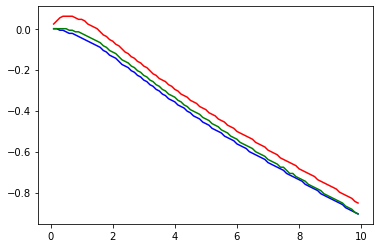

In [ ]:
sigma = 6.8
del_preceed = []
Se_preceed = []
SVD_preceed = []
v_list = np.arange(0.1,10,0.1)
for v in v_list:
    delSKvp, xaxis = StadyState_ConstMoveDelta(v, delSTK, dx, dt)
    delSKvpsig = np.convolve(delSKvp , GaussianWave(sigma), 'same')
    del_preceed.append(xaxis[np.argmax(delSKvpsig)])
    
    SeSKvp, xaxis = StadyState_ConstMoveDelta(v, SeSTK, dx, dt)
    SeSKvpsig = np.convolve(SeSKvp , GaussianWave(sigma), 'same')
    Se_preceed.append(xaxis[np.argmax(SeSKvpsig)])
    
    SVDSKvp, xaxis = StadyState_ConstMoveDelta(v, SVDSTK, dx, dt)
    SVDSKvpsig = np.convolve(SVDSKvp , GaussianWave(sigma), 'same')
    SVD_preceed.append(xaxis[np.argmax(SVDSKvpsig)])
    
plt.plot(v_list, del_preceed, c='b')
plt.plot(v_list, Se_preceed, c='r')
plt.plot(v_list, SVD_preceed, c='g')

## plot specific

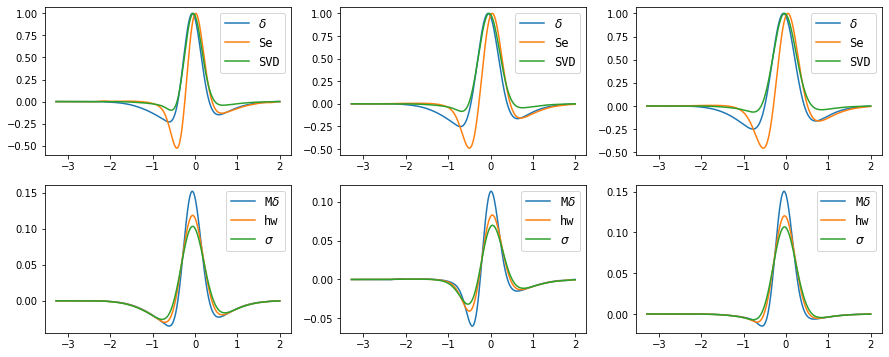

In [ ]:
v = 1.3
fig, ax = plt.subplots(2,3)
hw = 30
sigma = (2*hw+1)/np.sqrt(2*np.pi)

c = 0
for STK in [delSTK, SeSTK, SVDSTK]:
    SKvp, xaxis = StadyState_ConstMoveDelta(v, STK, dx, dt)

    ax[0][0].plot(xaxis, SKvp/max(SKvp))
    ax[1][c].plot(xaxis, SKvp)

    SKvphw = np.convolve(SKvp, SquareWave(hw), 'same')
    ax[0][1].plot(xaxis, SKvphw/max(SKvphw))
    ax[1][c].plot(xaxis, SKvphw/sum(SquareWave(hw)))

    SKvpsig = np.convolve(SKvp, GaussianWave(sigma), 'same')
    ax[0][2].plot(xaxis, SKvpsig/max(SKvpsig))
    ax[1][c].plot(xaxis, SKvpsig/sum(GaussianWave(sigma)))
    c+=1
    
for axi in ax[0]:
    axi.legend((r'$\delta$', 'Se', 'SVD'),loc='best', prop={'size': 'large', 'family': 'monospace'})
for axi in ax[1]:
    axi.legend((r'M$\delta$', 'hw', r'$\sigma$'),loc='best', prop={'size': 'large', 'family': 'monospace'})
fig.set_size_inches(15,6)